# Fraud Detection Model Training
This notebook trains and evaluates multiple machine learning models for fraud detection using different sampling strategies.

## Import Libraries
We start by importing all necessary libraries for data processing, modeling, and evaluation.

In [1]:

# ===== Libraries =====
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import joblib
import os
import warnings

warnings.filterwarnings("ignore")


## Helper Functions
Functions for loading, preprocessing the dataset, and evaluating models.

In [2]:
df=pd.read_csv('D:\Projects\Machine learning Projects\Fraud Detection Prediciton\sample_data.csv')

In [3]:
print("shape of df ", df.shape)

shape of df  (50000, 11)


In [4]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   step            50000 non-null  int64  
 1   type            50000 non-null  object 
 2   amount          50000 non-null  float64
 3   nameOrig        50000 non-null  object 
 4   oldbalanceOrg   50000 non-null  float64
 5   newbalanceOrig  50000 non-null  float64
 6   nameDest        50000 non-null  object 
 7   oldbalanceDest  50000 non-null  float64
 8   newbalanceDest  50000 non-null  float64
 9   isFraud         50000 non-null  int64  
 10  isFlaggedFraud  50000 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 4.2+ MB


In [6]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [7]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [8]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,50000.000000,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,50000.000000,50000.0
mean,7.453800,1.562645e+05,7.333083e+05,7.472741e+05,8.444671e+05,1.164400e+06,0.002000,0.0
std,2.056636,3.243949e+05,2.202405e+06,2.239971e+06,2.433388e+06,2.915203e+06,0.044677,0.0
min,1.000000,6.300000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0
25%,7.000000,7.734573e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0
50%,8.000000,3.341482e+04,1.703072e+04,0.000000e+00,2.126000e+03,0.000000e+00,0.000000,0.0
75%,9.000000,1.878390e+05,1.331716e+05,1.438734e+05,4.632050e+05,8.649264e+05,0.000000,0.0
max,9.000000,1.000000e+07,2.854724e+07,2.861740e+07,3.014320e+07,3.197699e+07,1.000000,0.0


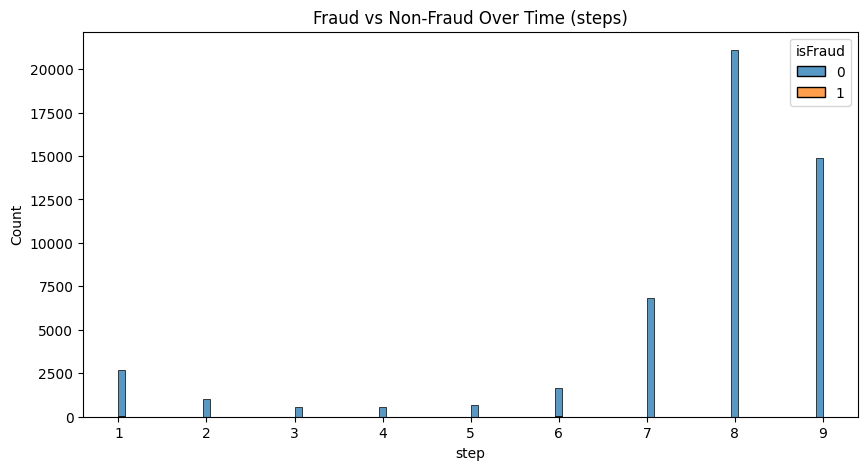

In [9]:
plt.figure(figsize=(10,5))
sns.histplot(data=df, x="step", hue="isFraud", multiple="stack", bins=100)
plt.title("Fraud vs Non-Fraud Over Time (steps)")
plt.show()

In [10]:
df['isFraud'].value_counts()

isFraud
0    49900
1      100
Name: count, dtype: int64

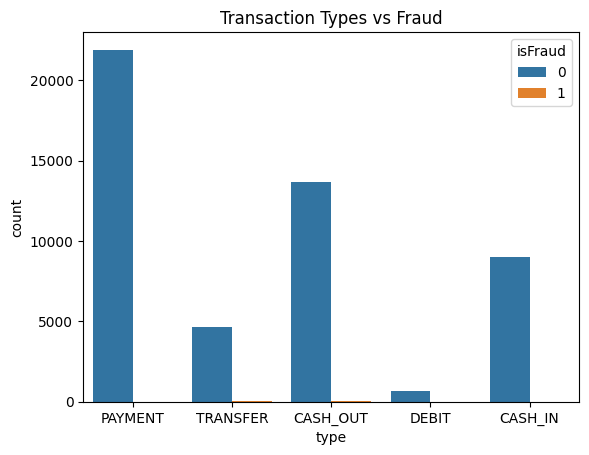

In [11]:
sns.countplot(data=df, x="type", hue="isFraud")
plt.title("Transaction Types vs Fraud")
plt.show()

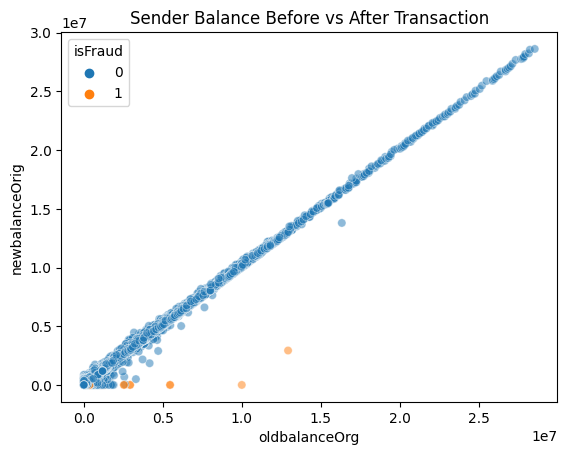

In [12]:
sns.scatterplot(data=df, x="oldbalanceOrg", y="newbalanceOrig", hue="isFraud", alpha=0.5)
plt.title("Sender Balance Before vs After Transaction")
plt.show()

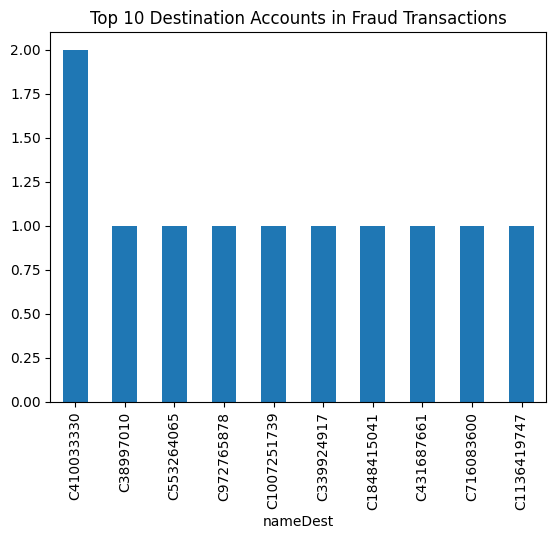

In [13]:
df[df['isFraud']==1]['nameDest'].value_counts().head(10).plot(kind='bar')
plt.title("Top 10 Destination Accounts in Fraud Transactions")
plt.show()

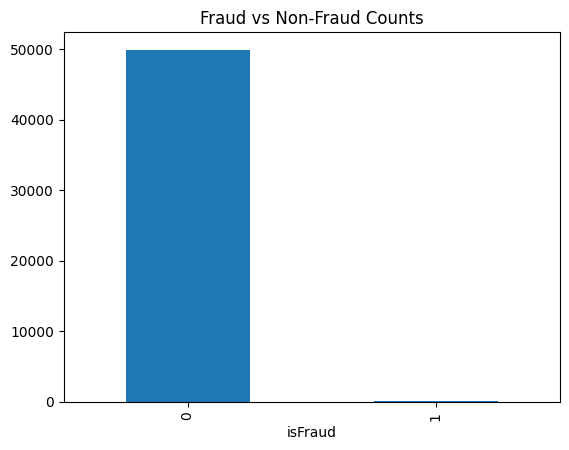

In [14]:
df['isFraud'].value_counts().plot(kind="bar")
plt.title("Fraud vs Non-Fraud Counts")
plt.show()

In [15]:
df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
49995,9,PAYMENT,1322.91,C1402545110,1208457.61,1207134.71,M578074960,0.0,0.0,0,0
49996,9,PAYMENT,6900.48,C517372485,1207134.71,1200234.22,M1854114037,0.0,0.0,0,0
49997,9,PAYMENT,17399.12,C1948160352,1200234.22,1182835.10,M1940330634,0.0,0.0,0,0
49998,9,PAYMENT,5485.20,C1586381033,1182835.10,1177349.90,M741912557,0.0,0.0,0,0


In [16]:
nums=df.select_dtypes(include=np.number)

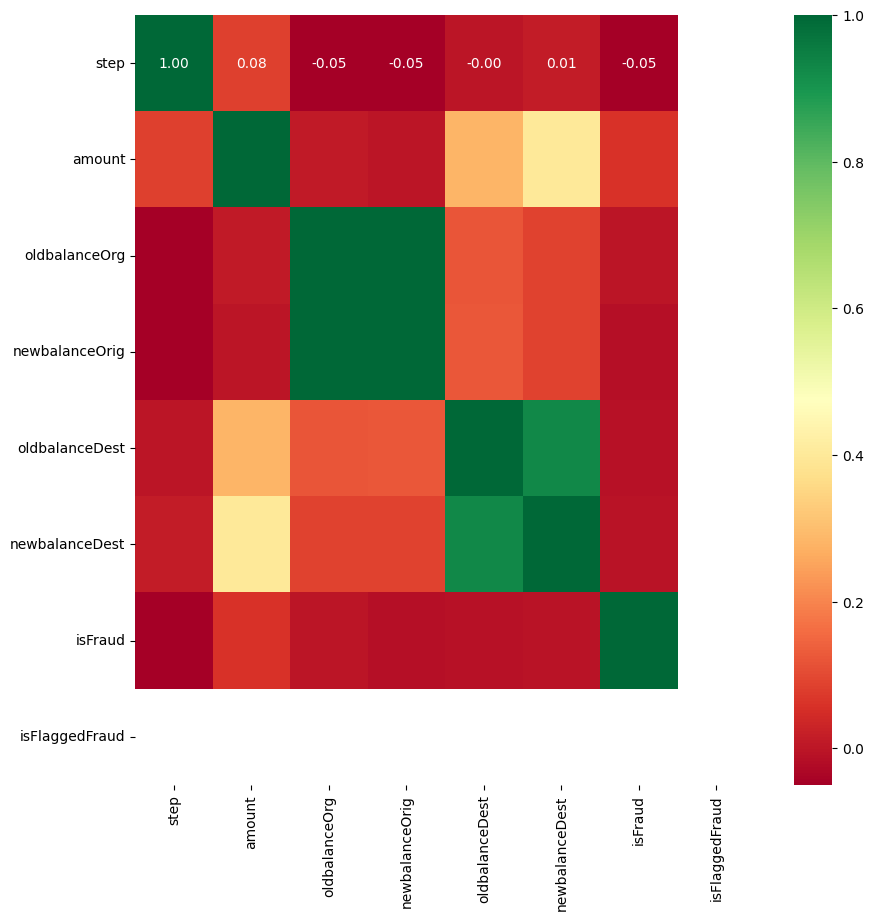

In [17]:
corr = nums.corr()
plt.subplots(figsize=(10,10))
sns.heatmap(corr,cmap= 'RdYlGn', fmt=".2f",annot=True)
plt.show()

In [18]:
def load_data(path):
    df = pd.read_csv(path)
    return df
def preprocess_data(df):
    for col in ["nameOrig", "nameDest"]:
        if col in df.columns:
            df = df.drop(col, axis=1)
    return df

def evaluate_model(y_true, y_pred, y_prob):
    return {
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1": f1_score(y_true, y_pred),
        "AUC": roc_auc_score(y_true, y_prob)
    }


## Define Models
We define a dictionary of machine learning models to train and compare.

In [19]:

# ===== Models =====
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
    "LightGBM": LGBMClassifier()
}


## K-Fold Training Function
This function performs Stratified K-Fold training, applies preprocessing and sampling, and saves the best model for each strategy.

In [20]:
# ===== K-Fold Training + Save Best Model per Strategy =====
def run_kfold(X, y, models, sampler=None, strategy="original", n_splits=5, save_dir="models"):
    os.makedirs(save_dir, exist_ok=True)
    results = {name: [] for name in models.keys()}
    best_models = {}

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    num_cols = X.select_dtypes(include=["int64", "float64"]).columns
    cat_cols = X.select_dtypes(include=["object"]).columns

    preprocessor = ColumnTransformer(transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ])

    for name, model in models.items():
        best_f1 = -1
        best_pipe = None

        for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

            steps = [("preprocessor", preprocessor)]
            if sampler:
                steps.append(("sampler", sampler))
            steps.append(("clf", model))

            pipe = ImbPipeline(steps=steps)
            pipe.fit(X_train, y_train)
            y_pred = pipe.predict(X_test)
            y_prob = pipe.predict_proba(X_test)[:, 1]
            metrics = evaluate_model(y_test, y_pred, y_prob)
            results[name].append(metrics)

            if metrics["F1"] > best_f1:
                best_f1 = metrics["F1"]
                best_pipe = pipe

        model_filename = f"{save_dir}/{strategy}_{name}_best.joblib"
        joblib.dump(best_pipe, model_filename)
        best_models[name] = best_pipe

    return results, best_models

## Summarize Results
Convert fold-wise metrics into a summary table with average scores.

In [21]:

# ===== Summarize Results =====
def summarize_results(results):
    summary = {}
    for name, metrics in results.items():
        df_metrics = pd.DataFrame(metrics)
        summary[name] = df_metrics.mean().to_dict()
    return pd.DataFrame(summary).T


## Load and Preprocess Data
Load the dataset, drop unnecessary columns, and split into features and target.

In [22]:

# ===== Load and Preprocess Data =====
df = load_data("D:\Projects\Machine learning Projects\Fraud Detection Prediciton\sample_data.csv")
df = preprocess_data(df)

X = df.drop("isFraud", axis=1)
y = df["isFraud"]


## Train Models with Different Strategies
Train models with different sampling strategies: Original, Under-sampling, Over-sampling, and SMOTE.

In [23]:

# ===== Training with Different Sampling Strategies =====
results_original, best_original = run_kfold(X, y, models, sampler=None, strategy="original")
summary_original = summarize_results(results_original)

# 2. Under-sampling
results_under, best_under = run_kfold(X, y, models, sampler=RandomUnderSampler(random_state=42), strategy="undersampling")
summary_under = summarize_results(results_under)

# 3. Over-sampling
results_over, best_over = run_kfold(X, y, models, sampler=RandomOverSampler(random_state=42), strategy="oversampling")
summary_over = summarize_results(results_over)

# 4. SMOTE
results_smote, best_smote = run_kfold(X, y, models, sampler=SMOTE(random_state=42), strategy="smote")
summary_smote = summarize_results(results_smote)


KeyboardInterrupt: 

## Display Results
Display the evaluation metrics for all strategies.

In [ ]:

# ===== Display Results =====
print("=== Original Data ===")
display(summary_original)

print("=== Under-sampling ===")
display(summary_under)

print("=== Over-sampling ===")
display(summary_over)

print("=== SMOTE ===")
display(summary_smote)
